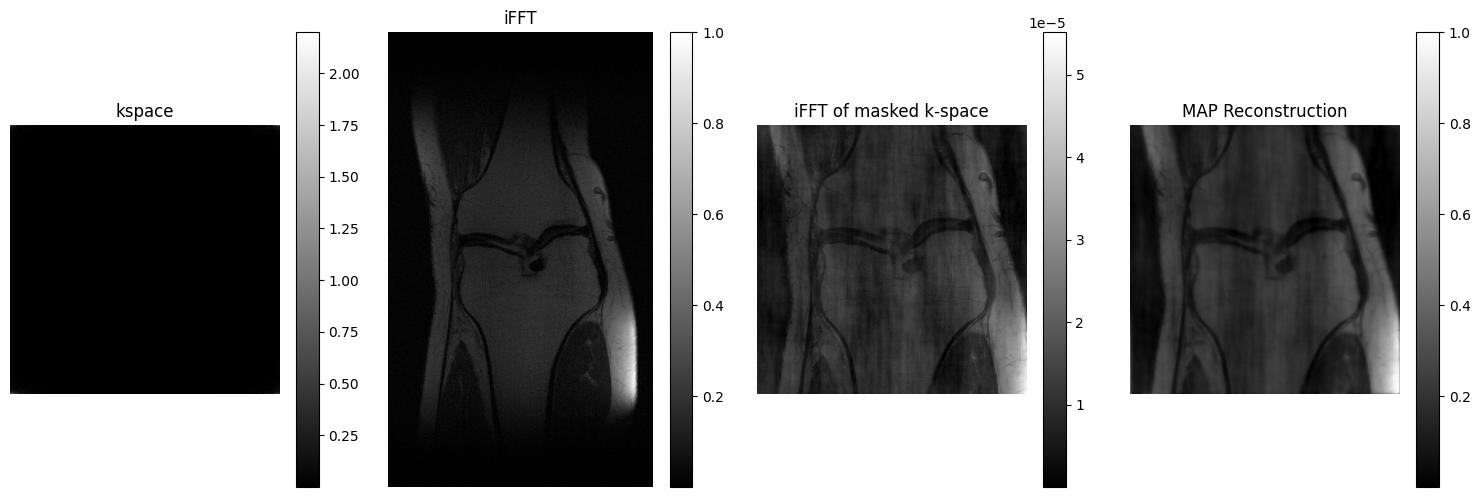

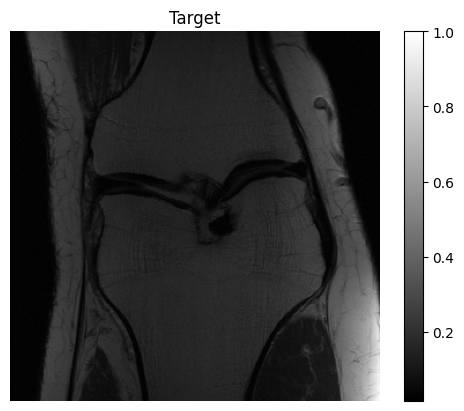

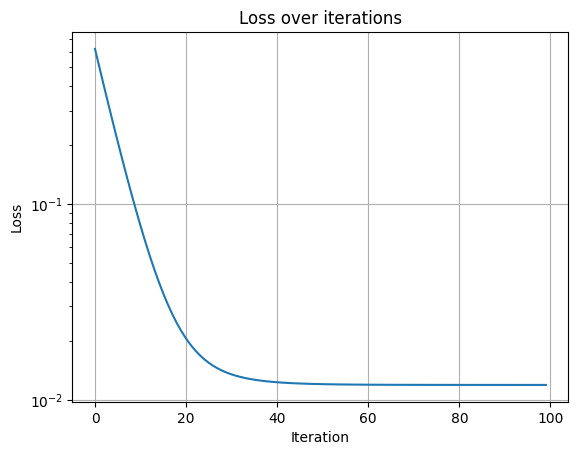

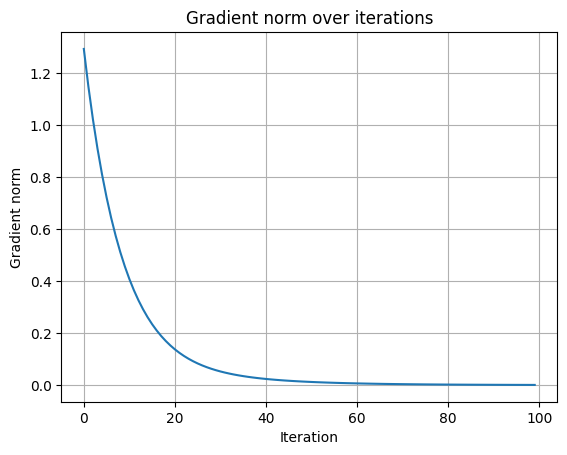

ULA iter    0, grad_norm=1.169e+04, sample_mean=9.766e-06, sample_std=5.971e-06
ULA iter   25, grad_norm=1.126e+79, sample_mean=3.036e+72, sample_std=1.780e+72
ULA iter   50, grad_norm=1.098e+154, sample_mean=-2.961e+147, sample_std=1.736e+147


C:\Users\kostanjsek\bachelor_project\MAP\map_tv_minimize.py:236: RuntimeWarning: overflow encountered in scalar divide
  data_term = np.linalg.norm(self.A(x) - y) ** 2 / (2 * self.sigma**2)
c:\Users\kostanjsek\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\linalg\_linalg.py:2791: RuntimeWarning: overflow encountered in dot
  sqnorm = x.dot(x)
c:\Users\kostanjsek\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\linalg\_linalg.py:2789: RuntimeWarning: overflow encountered in dot
  sqnorm = x_real.dot(x_real) + x_imag.dot(x_imag)
C:\Users\kostanjsek\bachelor_project\MAP\map_tv_minimize.py:202: RuntimeWarning: overflow encountered in add
  t = np.sqrt(dx**2 + dy**2 + 1e-8) # + 1e-8 to avoid division through 0
C:\Users\kostanjsek\bachelor_project\MAP\map_tv_minimize.py:203: RuntimeWarning: overflow encountered in divide
  quad = (t**2) / (2 * self.eps)
C:\Users\kostanjsek\bachelor_project\MAP\map_tv_minimize.py:148: RuntimeWarning: overflow encountered in add

ULA iter   75, grad_norm=inf, sample_mean=2.888e+222, sample_std=inf
ULA iter  100, grad_norm=inf, sample_mean=-2.817e+297, sample_std=inf
NaN/Inf detected at iteration 103
27


c:\Users\kostanjsek\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\fft\_pocketfft.py:101: RuntimeWarning: overflow encountered in fft
  return ufunc(a, fct, axes=[(axis,), (), (axis,)], out=out)
c:\Users\kostanjsek\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\fft\_pocketfft.py:101: RuntimeWarning: invalid value encountered in fft
  return ufunc(a, fct, axes=[(axis,), (), (axis,)], out=out)
C:\Users\kostanjsek\bachelor_project\MAP\map_tv_minimize.py:54: RuntimeWarning: invalid value encountered in multiply
  return self.M * np.fft.fft2(x, norm='ortho')
C:\Users\kostanjsek\bachelor_project\MAP\map_tv_minimize.py:60: RuntimeWarning: invalid value encountered in multiply
  return np.fft.ifft2(self.M * k_residual, norm='ortho')  # added .real


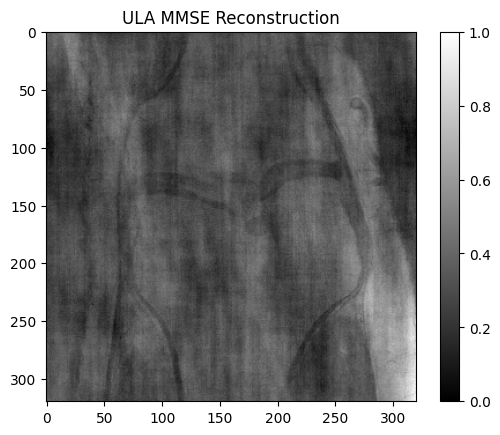

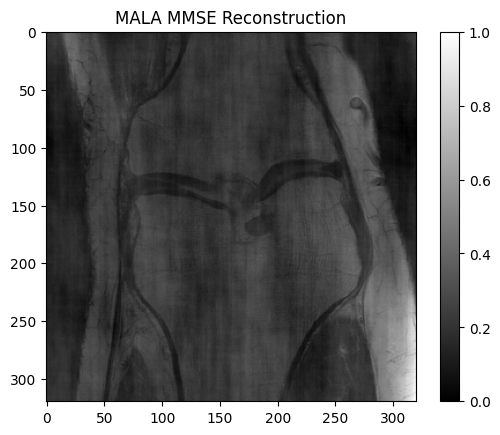

'\ndef pad_or_crop_to_match(src, target_shape):\n    """\n    Center pad or crop src to match target_shape (height, width, 2).\n    Assumes both are torch tensors.\n    """\n    src_h, src_w, _ = src.shape\n    tgt_h, tgt_w = target_shape\n\n    # If cropping\n    if src_h > tgt_h:\n        start_h = (src_h - tgt_h) // 2\n        src = src[start_h:start_h+tgt_h, :, :]\n    if src_w > tgt_w:\n        start_w = (src_w - tgt_w) // 2\n        src = src[:, start_w:start_w+tgt_w, :]\n\n    # If padding\n    if src_h < tgt_h:\n        pad_top = (tgt_h - src_h) // 2\n        pad_bottom = tgt_h - src_h - pad_top\n        src = torch.nn.functional.pad(src, (0, 0, 0, pad_bottom, 0, pad_top))\n    if src_w < tgt_w:\n        pad_left = (tgt_w - src_w) // 2\n        pad_right = tgt_w - src_w - pad_left\n        src = torch.nn.functional.pad(src, (0, 0, pad_left, pad_right))\n\n    return src\n\n\ndef to_complex_torch(x):\n    """\n    Convert x (NumPy or torch) to torch.complex64 tensor.\n    Suppor

In [1]:
import os
import sys
import fastmri
import fastmri.data
import fastmri.data.transforms
import h5py
import torch

# Set the path to the root of your project
project_root = os.path.abspath(os.path.join(os.getcwd(), r"C:\Users\kostanjsek\bachelor_project"))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
from MAP.masks import (
    SimpleMask,
    BernoulliMask,
    CenteredBernoulliMask,
    VariableDensityMask,
    PseudoRandomColumnMask
)
from fastmri.data import transforms as T
from fastmri.data.subsample import MaskFunc, RandomMaskFunc
from MAP.map_tv_minimize import MAPEstimator
from fastmri.data.mri_data import SliceDataset
from data.load_knee_mri import load_fastmri_data
from MMSE.mmse_ula import MMSEEstimatorULA
from MMSE.mmse_mala import MMSEEstimatorMALA

train_dataset, val_dataset, test_dataset = load_fastmri_data(
    r"C:\Users\kostanjsek\Documents\knee_mri"
)

file_name = r"C:\Users\kostanjsek\Documents\knee_mri\knee_singlecoil_train\singlecoil_train/file1000662.h5"
hf = h5py.File(file_name)

# def load_fastmri_sample(dataset, index):

#     file_path = dataset[index]
#     with h5py.File(file_path, 'r') as f:
#         keys = list(f.keys())
#         kspace = f['kspace'][:]
#         target = f['reconstruction_rss'][:] if 'reconstruction_rss' in f else None

#     return {
#         "keys": keys,
#         "kspace": kspace,
#         "target": target
#     }


volume_kspace = hf['kspace'][()]
target = hf['reconstruction_rss'][()]

slice_kspace = volume_kspace[20]
slice_target = target[20]  # match slice index to kspace slice
tensor_kspace = T.to_tensor(slice_kspace)


# if torch.is_complex(tensor_kspace):
#     slice_kspace = torch.view_as_real(tensor_kspace)

''' # k-space visualization
def show_volume_kspace(volume_kspace, slice_indices, cmap="gray"):
    fig, axes = plt.subplots(1, len(slice_indices), figsize=(15, 5))
    for i, idx in enumerate(slice_indices):
        kspace = volume_kspace[idx]
        kspace_mag = np.log(np.abs(kspace) + 1)   # magnitude + log scaling
        axes[i].imshow(kspace_mag, cmap=cmap)
        axes[i].set_title(f"Slice {idx}")
        axes[i].axis("off")
    plt.show()

# Example usage
#slice_indices = range(volume_kspace.shape[0])  # all slices
show_volume_kspace(volume_kspace, [0,1,2,20,21,22])
'''

# Zero-filled reconstruction: apply inverse FFT
# print(f"shape of slice_kspace: {slice_kspace.shape}")
# print(f"shape of slice_target: {slice_target.shape}")
# print(f"shape of tensor_kspace: {tensor_kspace.shape}")

reconstructed_image = fastmri.fftc.ifft2c_new(tensor_kspace) # Apply Inverse Fourier Transform to get the complex image
image_abs = fastmri.math.complex_abs(reconstructed_image) # Compute absolute value to get a real image
# print(f"shape of image_abs: {image_abs.shape} ")
# print(f"shape of reconstructed_image: {reconstructed_image.shape} ")
reconstructed_image_np = fastmri.data.transforms.tensor_to_complex_np(reconstructed_image)
highdim_kspace_np = fastmri.data.transforms.tensor_to_complex_np(tensor_kspace)

# print(f"shape of reconstructed_image_np: {reconstructed_image_np.shape}")

tensor_slice_target = T.to_tensor(slice_target)
tensor_slice_target = torch.stack((tensor_slice_target, torch.zeros_like(tensor_slice_target)), dim=-1)
reconstructed_kspace = fastmri.fftc.fft2c_new(tensor_slice_target)

# mask and MAP
#mask = VariableDensityMask('gaussian', 2, seed=30).generate(kspace.shape)
#mask = BernoulliMask(1, seed=30).generate(kspace.shape)

tensor_kspace_np = tensor_kspace.cpu().numpy()
if tensor_kspace_np.shape[-1] == 2:
    tensor_kspace_complex = tensor_kspace_np[..., 0] + 1j * tensor_kspace_np[..., 1]
else:
    tensor_kspace_complex = tensor_kspace_np

#mask = BernoulliMask(0.75, seed=30).generate(slice_target.shape)
#mask = VariableDensityMask('polynomial', 2, seed=30).generate(slice_kspace.shape)
#mask = VariableDensityMask('gaussian', 1.5, seed=30).generate(slice_target.shape)
#mask = PseudoRandomColumnMask(slice_target.shape, acceleration=2, seed=30).get_mask()
mask = CenteredBernoulliMask(0.75, 0.25, seed=30).generate(slice_target.shape)

# print('test')
# #print(np.max(np.abs(np.fft.fft2(slice_target)-slice_kspace)))  # andreas relevant

# plt.figure()
# plt.imshow(np.abs(slice_kspace))
# plt.show()
# plt.figure()
# plt.imshow(np.abs(np.fft.fft2(slice_target)))
# plt.show()

y = mask * np.fft.fft2(slice_target) # mask * slice_kspace
y = y / np.abs(y).max()

# print(f"y norm max abs = {np.max(np.abs(y_norm))}")
# print(f"y norm mean abs = {np.mean(np.abs(y_norm))}")
# print(f"y abs max = {np.max(np.abs(y))}")
# print(f"mean values of y = {np.mean(np.abs(y))}")

# print("Mask zeros:", np.sum(mask == 0))
# print("Mask ones:", np.sum(mask == 1))
# print("y difference from original:", np.linalg.norm(y - slice_kspace))


map_estimator = MAPEstimator(mask, 0.95, 0.01, 1e-2) # def-> 0.95, 0.01, 1e-2, 0.1, 100)
ula_estimator = MMSEEstimatorULA(mask, 0.01, 0.1, 1e-2, 0.1, 50, 2, 150) # stepsize = 1e-2
# mh_estimator = MHEstimator(mask, 0.95, 0.001, 1e-2, 0.5, 200, 3, 100)
mala_estimator = MMSEEstimatorMALA(mask, 1, 2, 100e-2, 1e-5, 450, 2, 100)

map_reconstruct = map_estimator.subgradient_descent(y)

# samples = map_estimator.langevin_sampling(y, 150, 20, 3)
# posterior_mean = np.mean(
#     samples, axis=0
# )  # Compute a point estimate (e.g., posterior mean)
# posterior_std = np.std(
#     samples, axis=0
# )  # Estimate uncertainty (e.g., pixel-wise variance)

# plot MAP
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title("kspace")
# plt.imshow(np.abs(np.fft.ifft2(y)), cmap='gray')
plt.imshow(np.log(1 + np.abs(np.fft.fft2(slice_target))), cmap="gray")
plt.colorbar()
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("iFFT")
plt.imshow(np.abs(reconstructed_image_np) / np.abs(reconstructed_image_np).max(), cmap="gray") # divide by .max() to get values [0,1]
plt.colorbar()
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("iFFT of masked k-space")
plt.imshow(np.abs(np.fft.ifft2(y)), cmap="gray")
plt.colorbar()
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("MAP Reconstruction")
plt.imshow(np.abs(map_reconstruct / map_reconstruct.max()), cmap="gray")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()

# target

plt.imshow(slice_target / slice_target.max(), cmap="gray")
plt.title("Target")
plt.colorbar()
plt.axis("off")
plt.show()

# langevin
#plt.imshow(posterior_mean, cmap="gray")
#plt.title("Posterior Mean Reconstruction")
#plt.colorbar()
#plt.show()

# loss
plt.plot(map_estimator.loss_history)
plt.title("Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.yscale('log')
plt.show()

# gradient
plt.plot(map_estimator.grad_norm_history)
plt.title("Gradient norm over iterations")
plt.xlabel("Iteration")
plt.ylabel("Gradient norm")
plt.grid(True)
#plt.yscale('log')
plt.show()

# ula mmse
plt.imshow(ula_estimator.compute_mmse_estimate(y), cmap="gray")
plt.title("ULA MMSE Reconstruction")
plt.colorbar()
plt.show()

# mala mmse
plt.imshow(mala_estimator.compute_mmse_estimate(y), cmap="gray")
plt.title("MALA MMSE Reconstruction")
plt.colorbar()
plt.show()


# mh mmse
# plt.imshow(mh_estimator.compute_mmse_estimate_hm(y), cmap="gray")
# plt.title("MH MMSE Reconstruction")
# plt.colorbar()
# plt.show()

#print(mmse_image)

# # ula mmse raw
# plt.imshow(samples[67].real, cmap="gray")
# plt.title("Raw ULA")
# plt.colorbar()
# plt.show()

# ula energy
# plt.plot(energies)
# plt.title("ULA energy over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("ULA energy")
# plt.grid(True)
# #plt.yscale('log')
# plt.show()

'''
def pad_or_crop_to_match(src, target_shape):
    """
    Center pad or crop src to match target_shape (height, width, 2).
    Assumes both are torch tensors.
    """
    src_h, src_w, _ = src.shape
    tgt_h, tgt_w = target_shape

    # If cropping
    if src_h > tgt_h:
        start_h = (src_h - tgt_h) // 2
        src = src[start_h:start_h+tgt_h, :, :]
    if src_w > tgt_w:
        start_w = (src_w - tgt_w) // 2
        src = src[:, start_w:start_w+tgt_w, :]

    # If padding
    if src_h < tgt_h:
        pad_top = (tgt_h - src_h) // 2
        pad_bottom = tgt_h - src_h - pad_top
        src = torch.nn.functional.pad(src, (0, 0, 0, pad_bottom, 0, pad_top))
    if src_w < tgt_w:
        pad_left = (tgt_w - src_w) // 2
        pad_right = tgt_w - src_w - pad_left
        src = torch.nn.functional.pad(src, (0, 0, pad_left, pad_right))

    return src


def to_complex_torch(x):
    """
    Convert x (NumPy or torch) to torch.complex64 tensor.
    Supports:
      - complex dtype arrays/tensors
      - real/imag format: last dim == 2, float dtype
    """
    # NumPy → Torch
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    
    # Ensure float or complex type
    if not (torch.is_floating_point(x) or torch.is_complex(x)):
        raise TypeError(f"Unsupported dtype {x.dtype}. Must be float or complex.")
    
    # Already complex
    if torch.is_complex(x):
        return x.to(torch.complex64)
    
    # fastMRI format: real/imag in last dim
    if x.shape[-1] == 2:
        return torch.view_as_complex(x.to(torch.float32))
    
    raise ValueError(f"Input shape {tuple(x.shape)} not recognized as complex or real/imag format.")

def kspace_metrics(k_ref, k_rec):
    """
    Compute MSE, NMSE, relative L2 error, max abs diff, and correlation for k-space tensors.
    Assumes fastMRI format: last dim = 2 (real, imag), dtype = float.
    """
    # Convert to complex dtype for easier math
    #k_ref_c = T.to_tensor(k_ref)
    #k_rec_c = T.to_tensor(k_rec)

    k_ref_c = to_complex_torch(k_ref)
    k_rec_c = to_complex_torch(k_rec)
    
    if k_ref_c.shape != k_rec_c.shape:
        raise ValueError(f"Shape mismatch: {k_ref_c.shape} vs {k_rec_c.shape}")

    # Difference
    diff = k_ref_c - k_rec_c

    # Metrics
    mse = torch.mean(torch.abs(diff) ** 2).item()
    nmse = (torch.sum(torch.abs(diff) ** 2) /
            torch.sum(torch.abs(k_ref_c) ** 2)).item()
    rel_l2 = (torch.linalg.norm(diff) /
              torch.linalg.norm(k_ref_c)).item()
    max_abs = torch.max(torch.abs(diff)).item()

    # Normalized correlation magnitude
    inner = torch.sum(k_rec_c.conj() * k_ref_c)
    corr = (torch.abs(inner) /
            (torch.linalg.norm(k_rec_c) * torch.linalg.norm(k_ref_c))).real.item()

    print(f"MSE:     {mse:.3e}")
    print(f"NMSE:    {nmse:.3e}")
    print(f"Rel L2:  {rel_l2:.3e}")
    print(f"Max abs: {max_abs:.3e}")
    print(f"Corr:    {corr:.6f}")
'''

# g_tv_true = map_estimator.huber_tv_subgradient(slice_target)
# plt.figure(figsize=(8,4))
# plt.subplot(1,2,1); plt.imshow(slice_target, cmap='gray'); plt.title('true image'); plt.axis('off')
# plt.subplot(1,2,2); plt.imshow(g_tv_true, cmap='RdBu'); plt.title('g_tv on true'); plt.colorbar(); plt.axis('off')
